# Exploratory Data Analysis on Building Energy Consumption

This notebook covers the in-depth exploratory data analysis (EDA) on the ASHRAE Great Energy Predictor III dataset. The competition challenges participants to accurately model four types of hourly metered building energy usage: chilled water, electric, hot water, and steam, based on historic usage rates and observed weather. The data include over 1,000 buildings across multiple sites over a three-year timeframe, and are pre-partitioned into training and testing data.

Link of the orignial dataset: https://www.kaggle.com/c/ashrae-energy-prediction


The basic profiling for the main data files with pandas profiling tool:

- [building_meta.csv profiles](https://georgehua.github.io/energy-consumption-prediction/building_metadata_profile.html)
- [train.csv profiles](https://georgehua.github.io/energy-consumption-prediction/trainset_profile.html)
- [weather_train.csv profiles](https://georgehua.github.io/energy-consumption-prediction/weather_train_profile.html)

TL;DR 

Takeaways from the EDA:

- There are 16 primary use types for the building in the dataset, education use has the most with a mix of residential and commercial buildings, and mostly built after the 1950s. Both the building square footage and floor counts are approximately logarithmically distributed, meaning most buildings are relatively small, single- to multi-story buildings. [Quick Jump](#finding1)

- Most buildings have a total meter reading between 10<sup>4</sup> to 10<sup>8</sup>. There're two buildings do not conform to the average Education load profiles. Building 1099 would have dominated the shape of the entire profile, owning to its orders-of-magnitude larger values, and the spike in November would have been preserved too. Building 740 on the other hand has near-zero, perfectly flat energy use throughout the year (note the y-axis values; these numbers can well be the measuring equipment bias!). We will therefore drop these two buildings. [Quick Jump](#finding2)

- Electricity and steam uses peak during Jun-Jul-Aug, as they are mostly associated with the use of spacing cooling. Similarly, steam and hot water peak during Dec-Jan-Feb due to space heating. Another interesting is the repeated weekly pattern in electricity use. This suggests that 'day of week' could also be a useful engineered feature. [Quick Jump](#finding3)

In [5]:
# Load useful modules
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
    
# Plots formatter

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

time: 0 ns


In [6]:
data_dir = "data/raw"/

# Read in the .csv files as Pandas DataFrame
bldg_meta = pd.read_csv(data_dir + 'building_metadata.csv')

train = pd.read_csv(data_dir + 'train.csv')
weather_train = pd.read_csv(data_dir + 'weather_train.csv')

test = pd.read_csv(data_dir + 'test.csv')
weather_test = pd.read_csv(data_dir + 'weather_test.csv')

sample_sub = pd.read_csv(data_dir + 'sample_submission.csv')

time: 31.9 s


In [15]:
print(bldg_meta.shape)
print(train.shape)
print(weather_train.shape)
print(test.shape)
print(weather_test.shape)

(1449, 6)
(20216100, 4)
(139773, 9)
(41697600, 4)
(277243, 9)
time: 0 ns


## 1. building_metadata.csv

In this section we will try and answer the following questions with the builing metadata, bldg_meta: 
* How many samples are in the DataFrame? 
* What are the feature variables?
* How are they distributed?

In [7]:
N, d = bldg_meta.shape
print(f'In bldg_meta, there are {N} samples and {d} features.')

print(f'The {d} features are: ', list(bldg_meta.columns))
print('Here are the first 10 rows of the DataFrame:')
print("")

bldg_meta.head(10)

In bldg_meta, there are 1449 samples and 6 features.
The 6 features are:  ['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']
Here are the first 10 rows of the DataFrame:



,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
5,0,5,Education,8000,2000.0,NaN
6,0,6,Lodging/residential,27926,1981.0,NaN
7,0,7,Education,121074,1989.0,NaN
8,0,8,Education,60809,2003.0,NaN
9,0,9,Office,27000,2010.0,NaN


time: 32 ms


There are in total 16 sites, labeled 0~15 (site_id), containing 1449 buildings. Each building is identified with a unique building_id independent from the site_id, from 0 to 1449, as tested in the following cell.

In [8]:
print(len(bldg_meta.site_id.unique()))
print(len(bldg_meta.building_id.unique()))

16
1449
time: 15 ms


We will note that over 75% of the buildings are missing floor_count data, and over 53% are missing year_built, as shown below. This may hinder their use as features for model training and prediction.

In [9]:
def missing_val_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    pct = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, pct], axis=1, keys=["Total Missing", "Percent"])

missing_val_table(bldg_meta)

,Total Missing,Percent
floor_count,1094,0.755003
year_built,774,0.534161
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


time: 63 ms


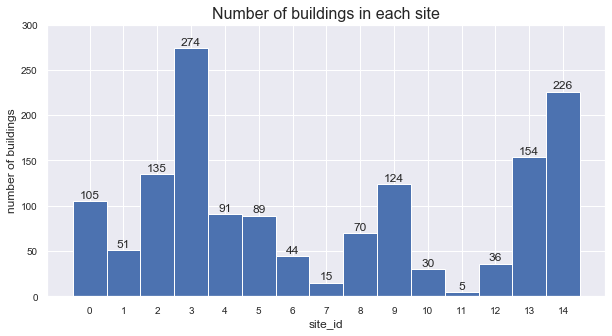

time: 500 ms


In [10]:
# Set up subplot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
n, bins, patches = ax.hist(bldg_meta.site_id, bins=15)

# Annotate each bar with the no. of buildings in that site:
for number, b in zip(n, bins[:-1]):
    ax.annotate(int(number), 
                 xy=(b+.5, number), xytext=(0, 1),#1 point vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)
# Set x ticks at the center of each bar
ax.set_xticks(np.arange(0.5, 15., step=1))
ax.set_xticklabels(np.arange(0, 15))
# Set y limits
ax.set_ylim([0, 300])
# Set x and y labels and add a title
ax.set_xlabel('site_id')
ax.set_ylabel('number of buildings')
ax.set_title('Number of buildings in each site', fontsize=16);

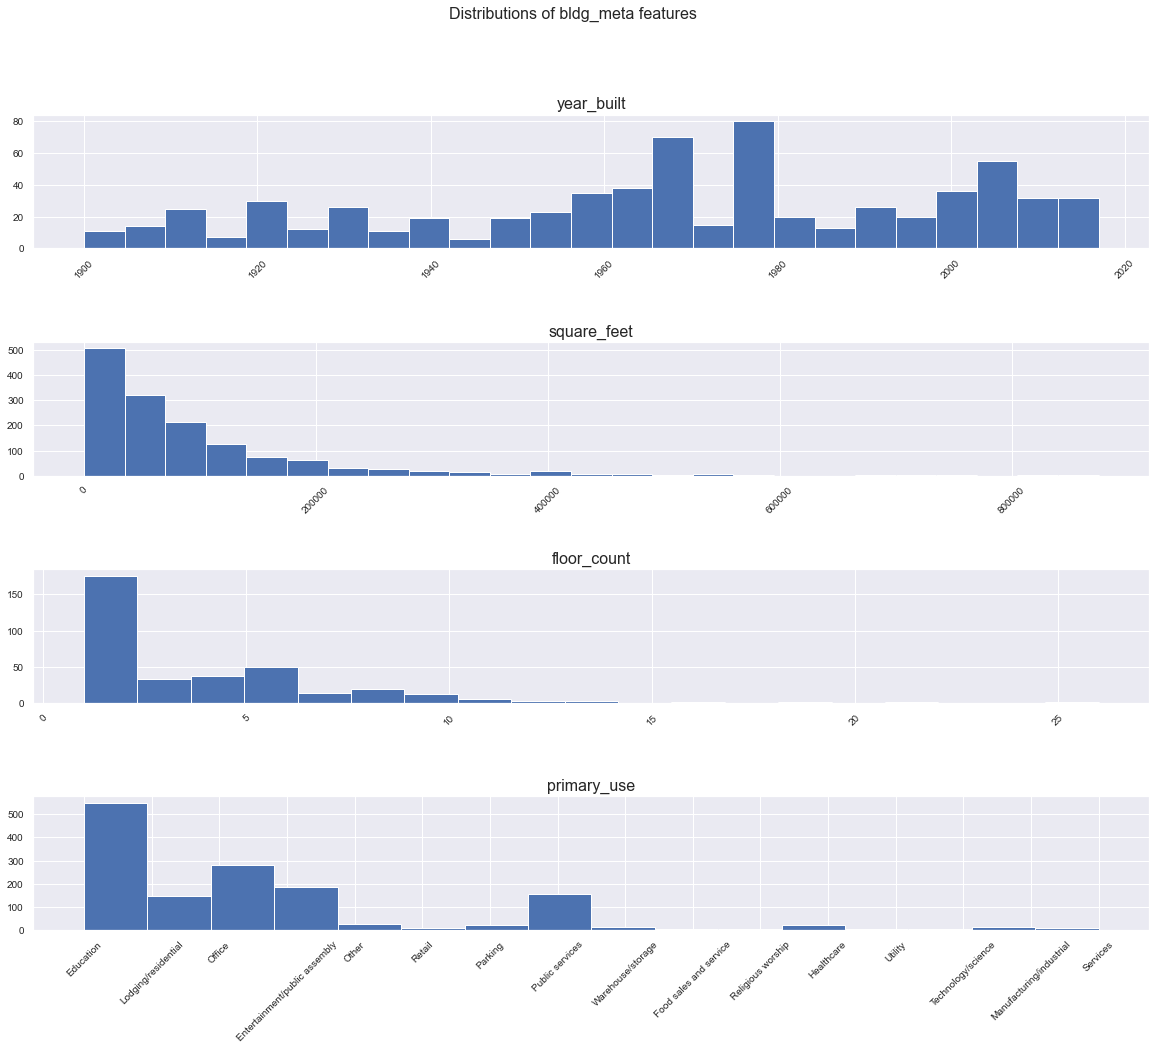

time: 1.06 s


In [16]:
fig, axes = plt.subplots(4, 1, figsize=(20, 15))
plt.subplots_adjust(hspace = 0.7)
targets = ["year_built", "square_feet", "floor_count", "primary_use"]
for row_i, row_name in enumerate(targets):
    bldg_meta[row_name].hist(xrot=45, ax=axes[row_i], bins=min(25, len(bldg_meta[row_name].unique())))
    axes[row_i].set_title(row_name)
fig.suptitle('Distributions of bldg_meta features');

<a id='finding1'></a>

There are 16 primary use types, education use has the most with a mix of residential and commercial buildings, and mostly built after the 1950s. Both the building square footage and floor counts are approximately logarithmically distributed, meaning most buildings are relatively small, single- to multi-story buildings. 

We can also compute the correlations between the features below. There's a fairly strong correlation between building square footage and floor counts (0.53), as we could expect, and a small but positive correlation (0.109) between the constructed year and the building size.

In [18]:
bldg_meta['year_built square_feet floor_count'.split()].corr()

,year_built,square_feet,floor_count
year_built,1.000000,0.109063,0.099393
square_feet,0.109063,1.000000,0.530298
floor_count,0.099393,0.530298,1.000000


time: 0 ns


## 2. train.csv

Although we are to predict the load profile, let's take a look at the total energy use (sum of all meter readings for each building), and its correlations with other features from bldg_meta, to see if it may guide our feature selections for model training.

In [18]:
# Compute the sum of meter readings
tot_meter_per_bldg = train[['building_id', 'meter_reading']].groupby('building_id').sum()
# Join with bldg_meta based on building_id
tot_meter_per_bldg = bldg_meta.merge(tot_meter_per_bldg, on='building_id')
tot_meter_per_bldg.rename(columns={'meter_reading': 'tot_meter_reading'}, inplace=True)
tot_meter_per_bldg.head(10)

,site_id,building_id,primary_use,square_feet,year_built,floor_count,tot_meter_reading
0,0,0,Education,7432,2008.0,NaN,1.286461e+06
1,0,1,Education,2720,2004.0,NaN,6.576176e+05
2,0,2,Education,5376,1991.0,NaN,1.278194e+05
3,0,3,Education,23685,2002.0,NaN,2.069071e+06
4,0,4,Education,116607,1975.0,NaN,8.578074e+06
5,0,5,Education,8000,2000.0,NaN,1.571848e+05
6,0,6,Lodging/residential,27926,1981.0,NaN,5.627611e+05
7,0,7,Education,121074,1989.0,NaN,2.558355e+07
8,0,8,Education,60809,2003.0,NaN,2.256854e+06
9,0,9,Office,27000,2010.0,NaN,5.468687e+06


time: 875 ms


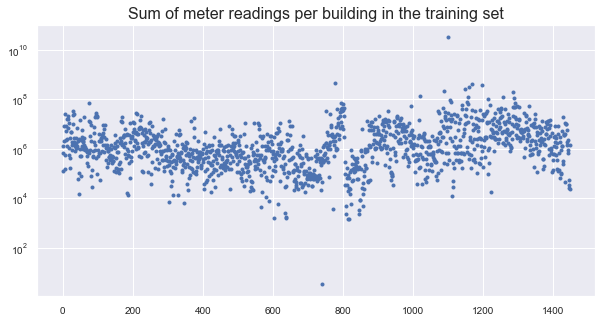

time: 328 ms


In [23]:
# Make the plot
tot_meter_per_bldg.tot_meter_reading.plot(logy=True, style='.', 
                                          title='Sum of meter readings per building in the training set', 
                                          x='building_id', y='total meter reading',
                                          figsize=(10, 5));

In [20]:
min_id = tot_meter_per_bldg.tot_meter_reading.sort_values(ascending=True).index[0]
max_id = tot_meter_per_bldg.tot_meter_reading.sort_values(ascending=True).index[-1]
tot_meter_per_bldg[(tot_meter_per_bldg.index==min_id)|(tot_meter_per_bldg.index==max_id)]

,site_id,building_id,primary_use,square_feet,year_built,floor_count,tot_meter_reading
740,5,740,Education,37975,1976.0,1.0,3.513400e+00
1099,13,1099,Education,332884,NaN,NaN,3.350620e+10


time: 16 ms


We notice that most buildings have a total meter reading between 10<sup>4</sup> to 10<sup>8</sup>, but the minimum and maximum are rather far away from the rest. We will extract their building ID and note them down.

After removing the outliners, we will compute the correlations between total meter readings and other features from bldg_meta. Total meter readings exhibit fairly signficant positive correlation with building square footage, and smaller but also positive correlations with floor counts and construction year.

In [21]:
tot_meter_per_bldg[(tot_meter_per_bldg.index!=min_id)
                   &(tot_meter_per_bldg.index!=max_id)][['square_feet', 'year_built', 'floor_count', 'tot_meter_reading']].corr()

,square_feet,year_built,floor_count,tot_meter_reading
square_feet,1.000000,0.109288,0.530109,0.347224
year_built,0.109288,1.000000,0.102462,0.135524
floor_count,0.530109,0.102462,1.000000,0.268675
tot_meter_reading,0.347224,0.135524,0.268675,1.000000


time: 16 ms


### Target variable time series profiles

In [22]:
# Join train with bldg_meta based on building_id
train_meta = bldg_meta.merge(train, on='building_id')
train_meta['timestamp'] = pd.to_datetime(train_meta.timestamp)
train_meta.head(10)

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 00:00:00,0.0
1,0,0,Education,7432,2008.0,NaN,0,2016-01-01 01:00:00,0.0
2,0,0,Education,7432,2008.0,NaN,0,2016-01-01 02:00:00,0.0
3,0,0,Education,7432,2008.0,NaN,0,2016-01-01 03:00:00,0.0
4,0,0,Education,7432,2008.0,NaN,0,2016-01-01 04:00:00,0.0
5,0,0,Education,7432,2008.0,NaN,0,2016-01-01 05:00:00,0.0
6,0,0,Education,7432,2008.0,NaN,0,2016-01-01 06:00:00,0.0
7,0,0,Education,7432,2008.0,NaN,0,2016-01-01 07:00:00,0.0
8,0,0,Education,7432,2008.0,NaN,0,2016-01-01 08:00:00,0.0
9,0,0,Education,7432,2008.0,NaN,0,2016-01-01 09:00:00,0.0


time: 18.2 s


In [23]:
# Get a list of primary uses and its length
prim_use_list = train_meta['primary_use'].unique()
len(prim_use_list)

16

time: 938 ms


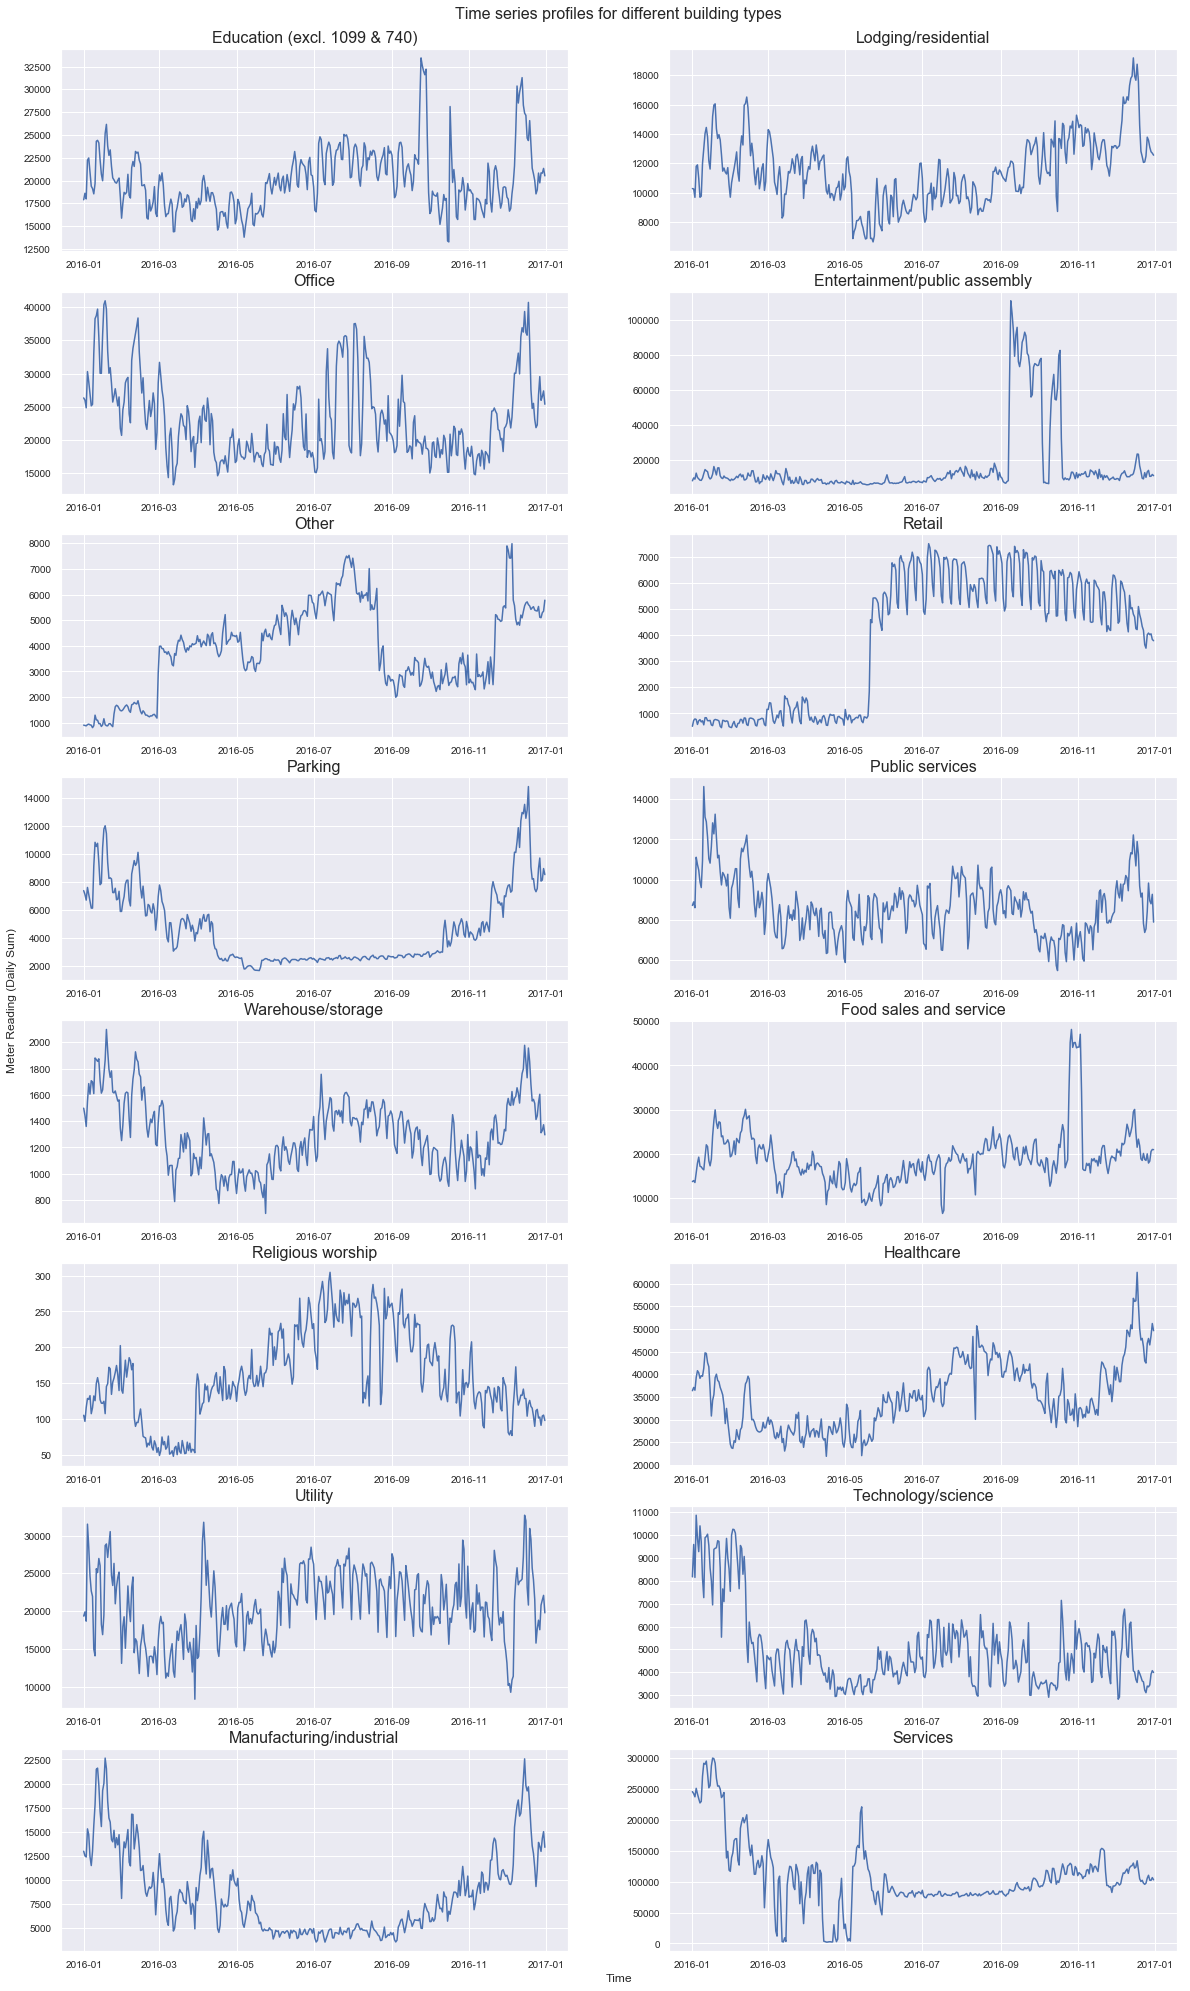

time: 33 s


In [24]:
# Group by primary use and plot time series profiles
fig, axes = plt.subplots(8, 2, figsize=(20, 35))

# For education buildings, we will drop the two outliers we identified earlier for now; explanation comes later. 
edu_df = train_meta[(train_meta['primary_use']=='Education')&(train_meta['building_id']!=min_id)&(train_meta['building_id']!=max_id)]
# Daily energy use for each building
edu_daily = edu_df.groupby(['building_id', edu_df['timestamp'].dt.date])['meter_reading'].sum()
edu_daily = edu_daily.reset_index()
edu_mean = edu_daily.groupby('timestamp')['meter_reading'].mean()
axes[0, 0].plot(edu_mean.index, edu_mean)
axes[0, 0].set_title('Education (excl. 1099 & 740)')

# For the rest of the building types we will write a loop for batch ploting:
for ax, use in zip(axes.flat[1:], prim_use_list[1:]): 
    prim_use_df = train_meta[train_meta['primary_use']==use]
    prim_use_daily = prim_use_df.groupby(['building_id', prim_use_df['timestamp'].dt.date])['meter_reading'].sum()
    prim_use_daily = prim_use_daily.reset_index()
    mean = prim_use_daily.groupby('timestamp')['meter_reading'].mean()
    
    ax.plot(mean.index, mean)
    ax.set_title(use)

# The following lines help create common X and Y labels.
# Borrowed from: https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots/36542971#36542971
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Daily Sum)', labelpad=20)

plt.title('Time series profiles for different building types', pad=30)
plt.show()

From the annual load profiles for the average daily energy use, we can see that Education, Lodging/Residential, Office, Public Services, Warehouse/Storage and Healthcare, where heating, ventilation and air conditioning (HVAC) are important to maintain indoor temperatures, tend to have two peaks in their annual profiles (albeit of different patterns and magnitudes), one around June-July-August (JJA) and another around December-Janurary-Feburary (DJF). These coincide with the summer and winter seasons (of the Northern Hemisphere; and the other way around for the Southern Hemisphere), respectively. This is suggestive that weather data will play an important role in prediciting load profiles for these buildings, and 'month of year' could be a useful engineered feature.

In [25]:
train_meta['month'] = train_meta['timestamp'].dt.month

time: 1.48 s


Now we will explain why we excluded the previously identified outliers: 1099 and 740, both of which happen to be educational builidngs. We will plot their profiles to see if there's anything strange about them:

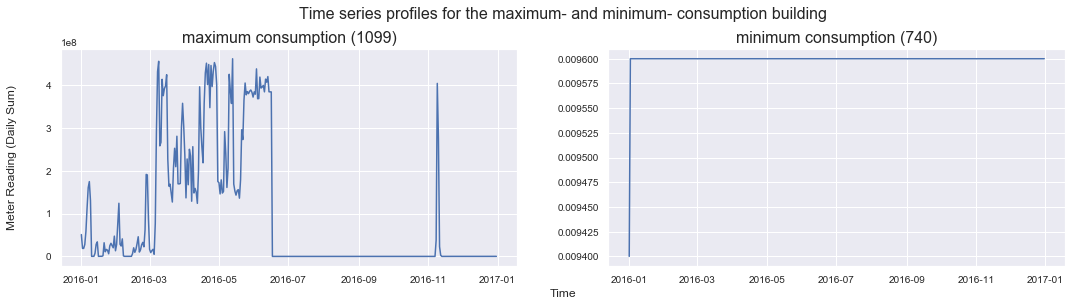

time: 14.8 s


In [26]:
# Outliers: 
max_edu_daily = train_meta[train_meta['building_id']==max_id].groupby(train_meta['timestamp'].dt.date)['meter_reading'].sum()
min_edu_daily = train_meta[train_meta['building_id']==min_id].groupby(train_meta['timestamp'].dt.date)['meter_reading'].sum()

fig, axes = plt.subplots(1, 2, figsize=(18, 4))
axes[0].plot(max_edu_daily.index, max_edu_daily)
axes[0].set_title(f'maximum consumption ({max_id})')
axes[1].plot(min_edu_daily.index, min_edu_daily)
axes[1].set_title(f'minimum consumption ({min_id})')

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Daily Sum)', labelpad=20)

plt.title('Time series profiles for the maximum- and minimum- consumption building', pad=30)
plt.show()

<a id="finding2"></a>
It is clear that both of these buildings do not conform to the average Education load profiles. Building 1099 would have dominated the shape of the entire profile, owning to its orders-of-magnitude larger values, and the spike in November would have been preserved too. Building 740 on the other hand has near-zero, perfectly flat energy use throughout the year (note the y-axis values; these numbers can well be the measuring equipment bias!). We will therefore drop these two buildings for the following discussion and when training the model.

In [27]:
train_meta_no_outlier = train_meta[(train_meta['building_id']!=min_id)&(train_meta['building_id']!=max_id)]

time: 1.34 s


### Meter time series profiles

We will start with making the average daily profiles for different meters.

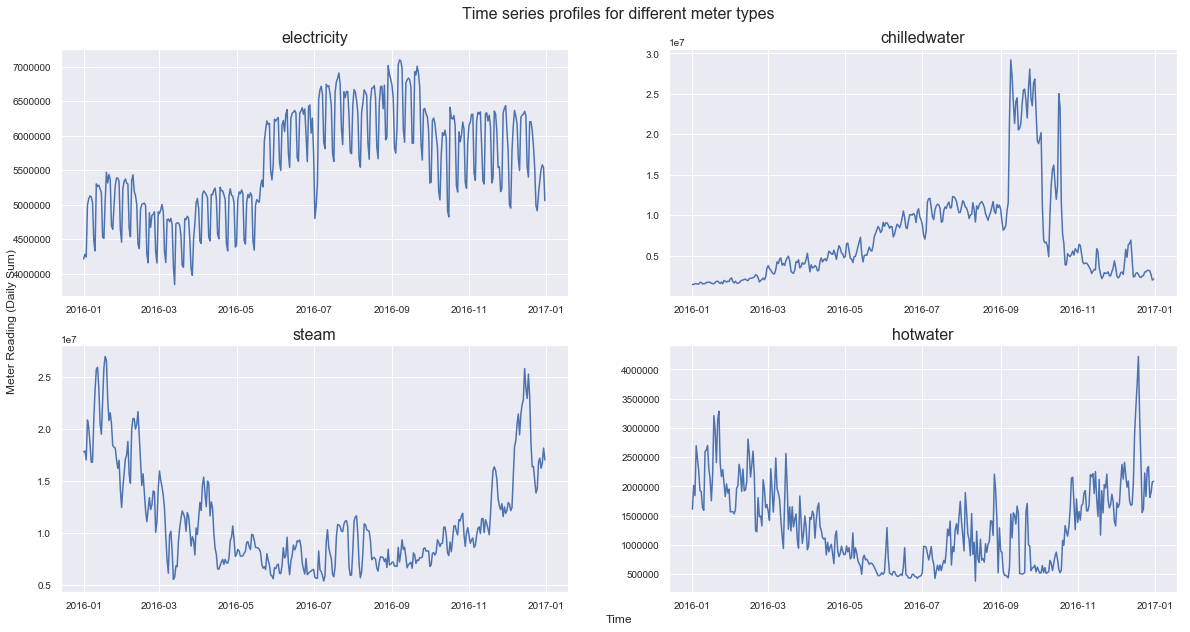

time: 36.8 s


In [28]:
meters = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for ax, m in zip(axes.flat, meters): 
    meter_df = train_meta_no_outlier[train_meta_no_outlier['meter']==m]
    meter_daily = meter_df.groupby(['meter', meter_df['timestamp'].dt.date])['meter_reading'].sum()
    meter_daily = meter_daily.reset_index()
    mean = meter_daily.groupby('timestamp')['meter_reading'].mean()
    
    ax.plot(mean.index, mean)
    ax.set_title(meters[m])

# The following lines help create common X and Y labels.
# Borrowed from: https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots/36542971#36542971
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Daily Sum)', labelpad=20)

plt.title('Time series profiles for different meter types', pad=30)
plt.show()

<a id="finding3"></a>

As we can expect, electricity and steam uses peak during JJA, as they are mostly associated with the use of spacing cooling. Similarly, steam and hot water peak during DJF due to space heating. 
Another interesting feature we note is the repeated weekly pattern in electricity use. This suggests that 'day of week' could also be a useful engineered feature.

In [ ]:
train_meta_no_outlier['day_of_week'] = train_meta_no_outlier['timestamp'].dt.weekday

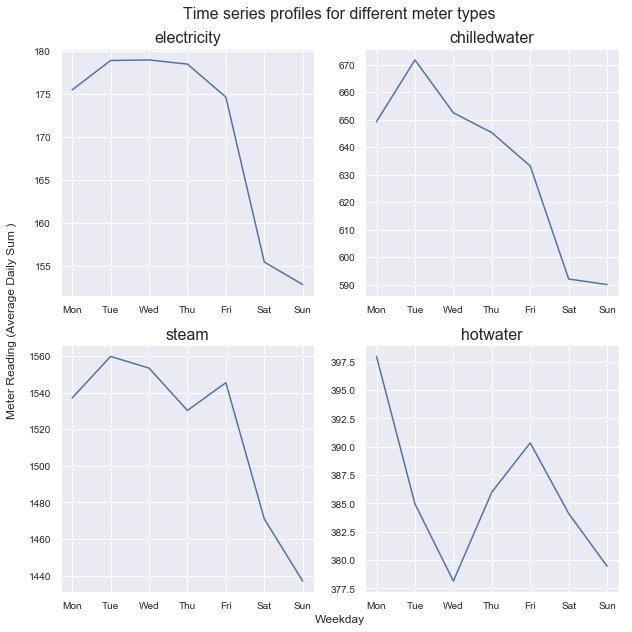

time: 4.08 s


In [30]:
# Visualize weekly profiles
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, m in zip(axes.flat, meters): 
    mean = train_meta_no_outlier[train_meta_no_outlier['meter']==m].groupby('day_of_week')['meter_reading'].mean()
    
    ax.plot(mean.index, mean)
    ax.set_title(meters[m])
    ax.set_xticks(np.arange(0, 7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Weekday')
plt.ylabel('Meter Reading (Average Daily Sum )', labelpad=20)

plt.title('Time series profiles for different meter types', pad=30)
plt.show()

### Site time series profiles

How what the energy consumption for each site looks like.

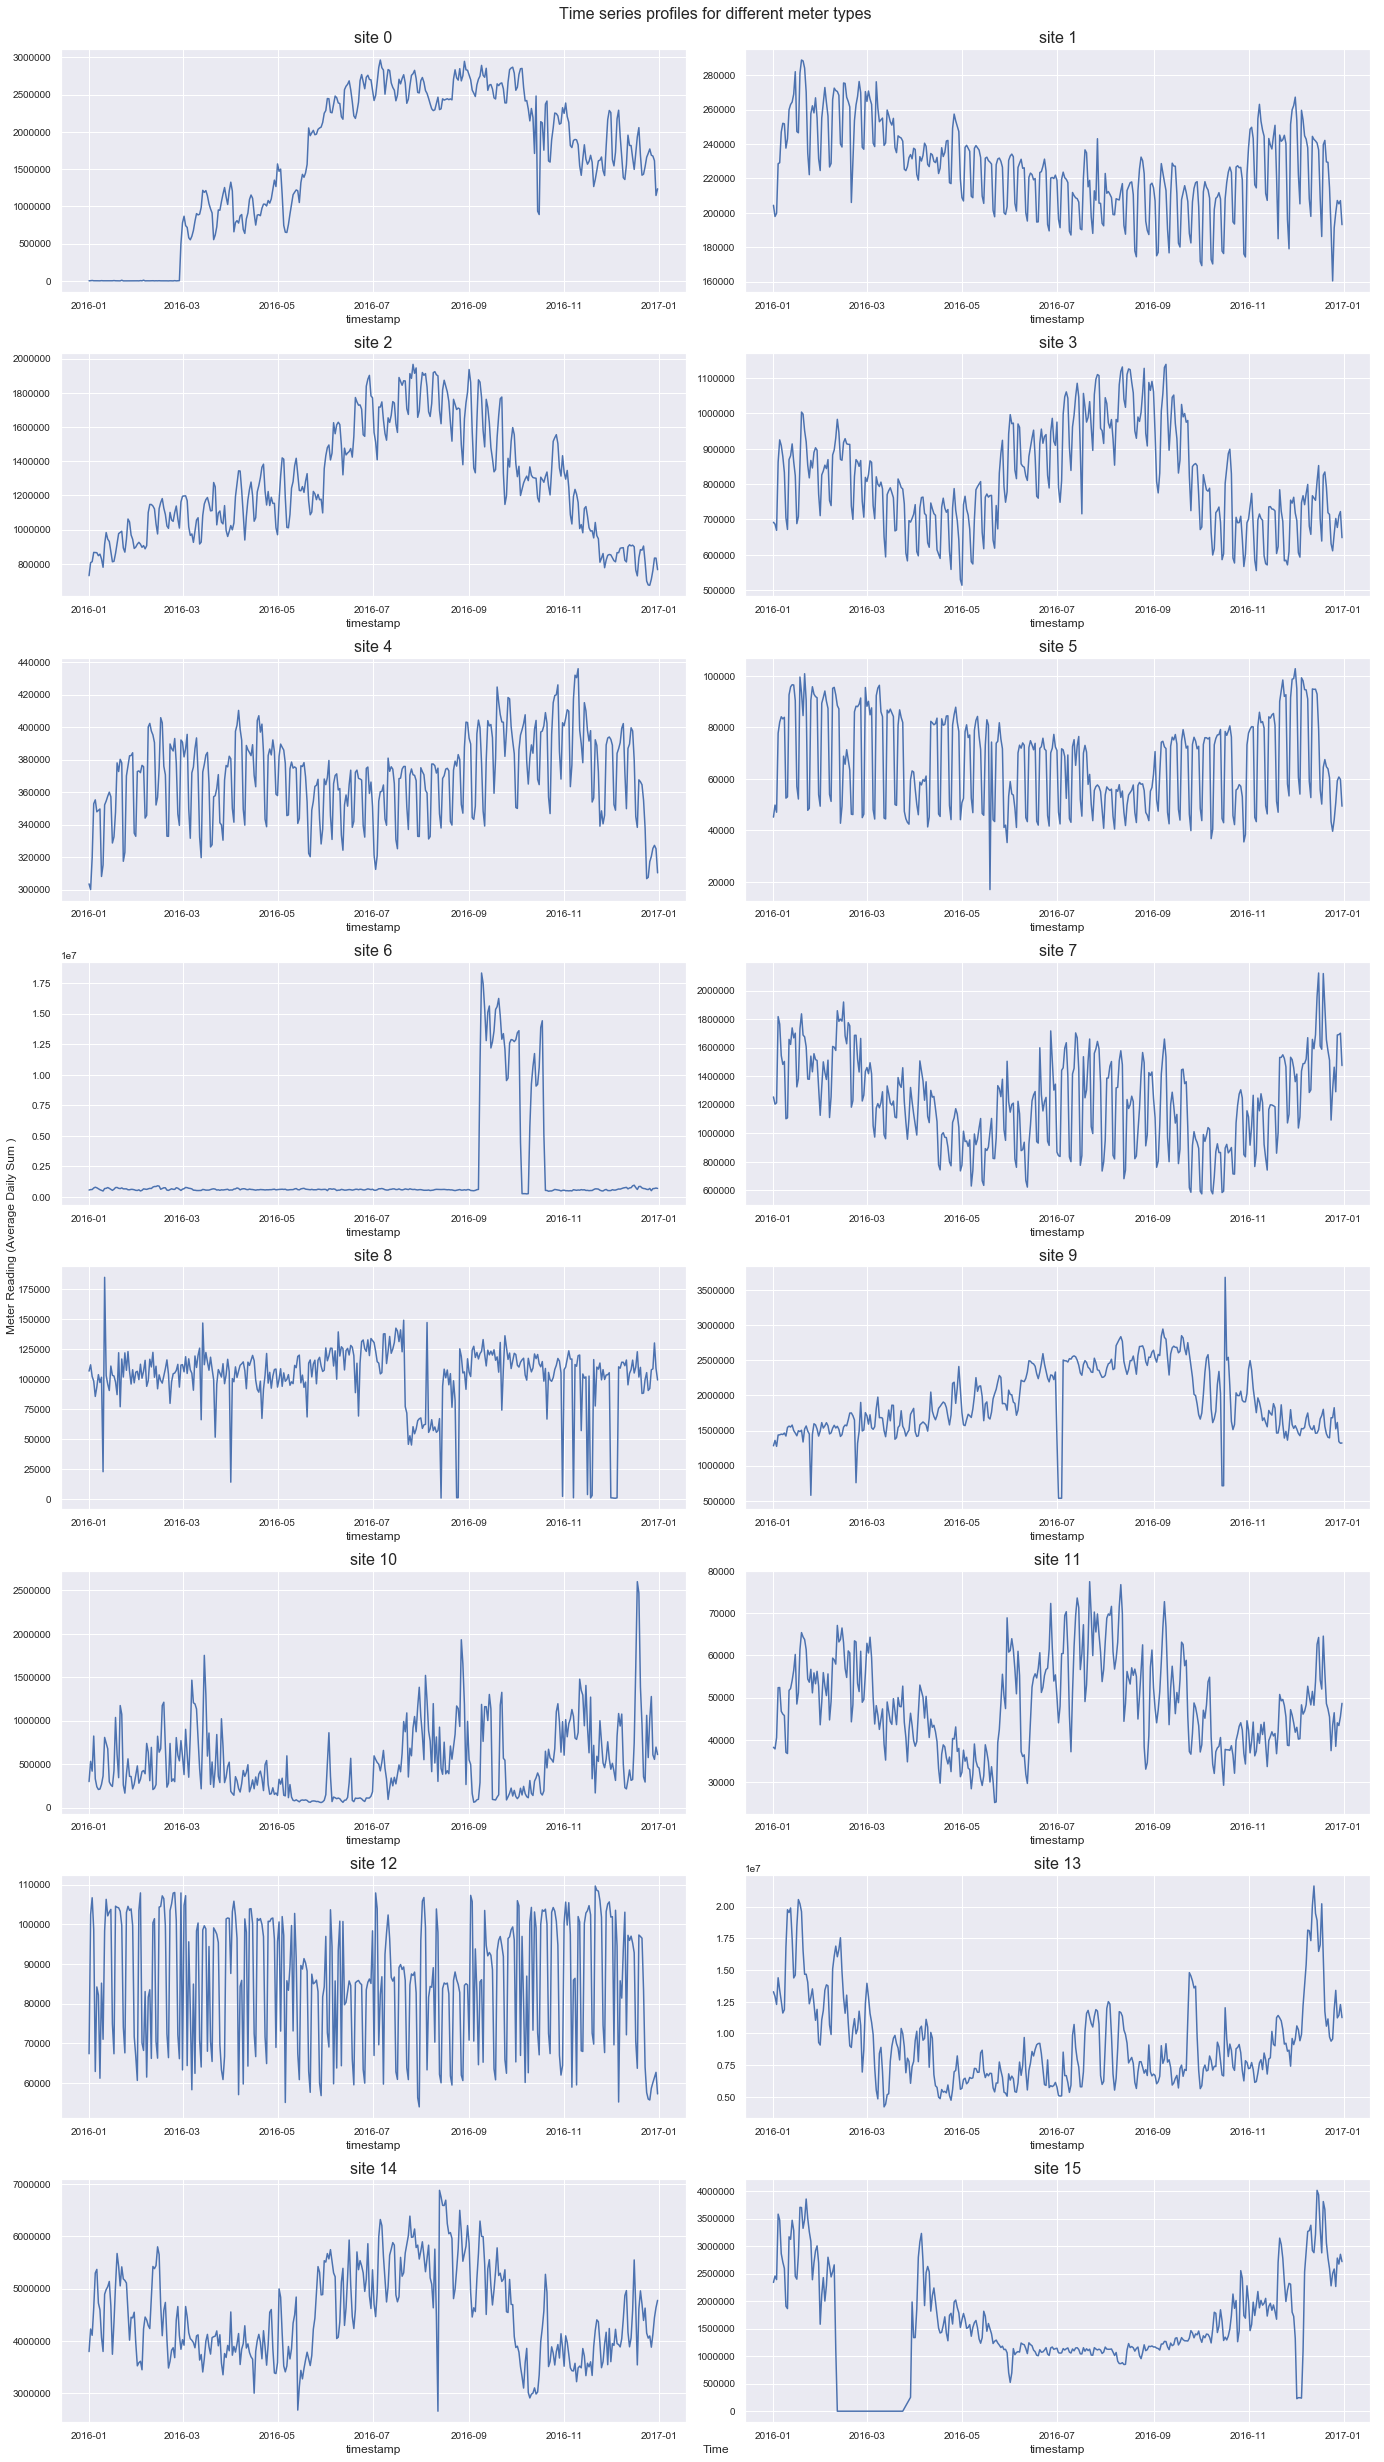

time: 15.8 s


In [31]:
# Load profiles by site_id
site_daily_sum = train_meta_no_outlier.groupby(['site_id', train_meta_no_outlier.timestamp.dt.date])['meter_reading'].sum().reset_index()

fig, axes = plt.subplots(8, 2, figsize=(20, 35), tight_layout=True)
for i, ax in zip(range(16), axes.flat):
    site_daily_sum[site_daily_sum.site_id == i][['timestamp', 'meter_reading']].plot(ax = ax, x = 'timestamp', legend=False);
    ax.set_title(f'site {i}')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Average Daily Sum )', labelpad=20)

plt.title('Time series profiles for different meter types', pad=30)
plt.show()

As we can see in the figure above, Site 0 had zero meter reading until March 2016. It could be that the site did not come into use until the time. This means that we might need to discard the zeros when training our models. The same may be true to Site 15, where between Feburary and March there is zero meter readings for about a month.

## Weather Data

weather_train has 2016 hourly weather data, and weather_test has 2017~18 hourly weather data.

In [32]:
weather_train['timestamp'] = pd.to_datetime(weather_train.timestamp)
weather_test['timestamp'] = pd.to_datetime(weather_test.timestamp)

print(f'weather_train: {weather_train.shape}')
display(weather_train.head())

print(f'weather_test: {weather_test.shape}')
display(weather_test.head())

weather_train: (139773, 9)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


weather_test: (277243, 9)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


time: 312 ms


In [33]:
print("weahter_train missing values")
print(missing_val_table(weather_train))
print("")
print("weahter_test missing values")
print(missing_val_table(weather_test))

weahter_train missing values
                    Total Missing   Percent
cloud_coverage              69173  0.494895
precip_depth_1_hr           50289  0.359791
sea_level_pressure          10618  0.075966
wind_direction               6268  0.044844
wind_speed                    304  0.002175
dew_temperature               113  0.000808
air_temperature                55  0.000393
timestamp                       0  0.000000
site_id                         0  0.000000

weahter_test missing values
                    Total Missing   Percent
cloud_coverage             140448  0.506588
precip_depth_1_hr           95588  0.344781
sea_level_pressure          21265  0.076702
wind_direction              12370  0.044618
wind_speed                    460  0.001659
dew_temperature               327  0.001179
air_temperature               104  0.000375
timestamp                       0  0.000000
site_id                         0  0.000000
time: 78 ms


We will visualize the time series of both the training and testing weather data below.

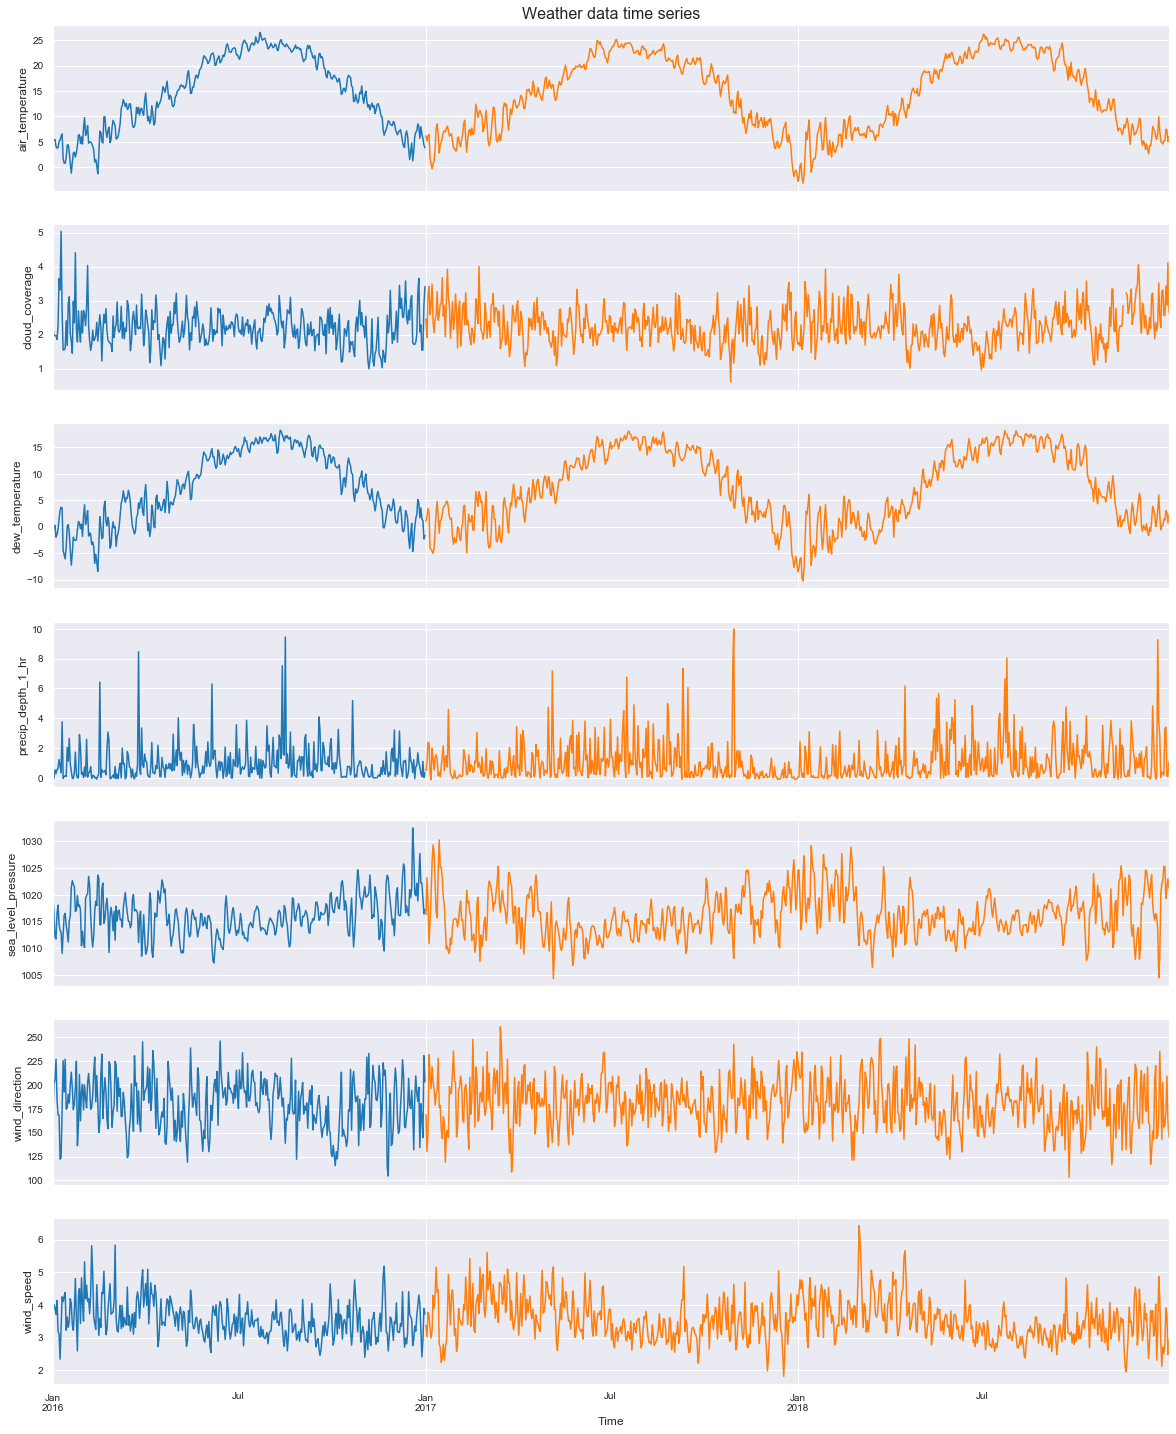

time: 4.83 s


In [34]:
fig, axes = plt.subplots(7, 1, sharex=True, figsize=(20, 25))

for col, ax in zip(weather_train.columns[2:], axes):
    weather_train[['timestamp', col]].set_index('timestamp').resample('D').mean()[col].plot(ax=ax, color='tab:blue', label='train')
    weather_test[['timestamp', col]].set_index('timestamp').resample('D').mean()[col].plot(ax=ax, color='tab:orange', label='test')
    ax.set_ylabel(col)

axes[0].set_title('Weather data time series')
axes[-1].set_xlabel('Time')
plt.show()

## Putting things together

We have looked at each dataset seperately, now we will join the train, weather_train and bldg_meta to see if there are any correlations between these variables.

In [35]:
train_meta_weather_no_outlier = train_meta_no_outlier.merge(weather_train, on=['site_id', 'timestamp'])
train_meta_weather_no_outlier.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading,month,day_of_week,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01,0.0,1,4,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,1,Education,2720,2004.0,NaN,0,2016-01-01,0.0,1,4,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,0,2,Education,5376,1991.0,NaN,0,2016-01-01,0.0,1,4,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,0,3,Education,23685,2002.0,NaN,0,2016-01-01,0.0,1,4,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,0,4,Education,116607,1975.0,NaN,0,2016-01-01,0.0,1,4,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


time: 9.2 s


Because we are predicting hourly meter reading, we will add hour as an engineered feature as well:

In [36]:
train_meta_weather_no_outlier['hour'] = train_meta_weather_no_outlier.timestamp.dt.hour

time: 1.5 s


Now we will compute meter-specific correlations:

In [38]:
for m in meters:
    print(meters[m])
    display(train_meta_weather_no_outlier[train_meta_weather_no_outlier.meter==m][train_meta_weather_no_outlier.columns[-8:]].corr())

electricity


,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
air_temperature,1.000000,0.047030,0.758612,-0.000540,-0.285414,-0.095482,-0.075877,0.123289
cloud_coverage,0.047030,1.000000,0.161690,0.128088,-0.136495,0.028325,0.235215,0.045641
dew_temperature,0.758612,0.161690,1.000000,0.068933,-0.202006,-0.165844,-0.129838,-0.002948
precip_depth_1_hr,-0.000540,0.128088,0.068933,1.000000,-0.060916,-0.011311,0.033863,0.005416
sea_level_pressure,-0.285414,-0.136495,-0.202006,-0.060916,1.000000,-0.103141,-0.205365,0.000540
wind_direction,-0.095482,0.028325,-0.165844,-0.011311,-0.103141,1.000000,0.405662,0.050018
wind_speed,-0.075877,0.235215,-0.129838,0.033863,-0.205365,0.405662,1.000000,0.145086
hour,0.123289,0.045641,-0.002948,0.005416,0.000540,0.050018,0.145086,1.000000


chilledwater


,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
air_temperature,1.000000,0.082450,0.713668,-0.012685,-0.378770,-0.086810,-0.082210,0.108365
cloud_coverage,0.082450,1.000000,0.082663,0.097037,-0.203100,0.036896,0.208556,0.055435
dew_temperature,0.713668,0.082663,1.000000,0.073567,-0.239026,-0.184301,-0.172812,0.003450
precip_depth_1_hr,-0.012685,0.097037,0.073567,1.000000,-0.056838,-0.004045,0.038710,0.000335
sea_level_pressure,-0.378770,-0.203100,-0.239026,-0.056838,1.000000,-0.102112,-0.210716,0.010876
wind_direction,-0.086810,0.036896,-0.184301,-0.004045,-0.102112,1.000000,0.462771,0.064853
wind_speed,-0.082210,0.208556,-0.172812,0.038710,-0.210716,0.462771,1.000000,0.154759
hour,0.108365,0.055435,0.003450,0.000335,0.010876,0.064853,0.154759,1.000000


steam


,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
air_temperature,1.000000,-0.045263,0.906003,0.010883,-0.272823,-0.142265,-0.155639,0.128796
cloud_coverage,-0.045263,1.000000,0.010689,0.112704,-0.207174,0.090495,0.275116,0.060937
dew_temperature,0.906003,0.010689,1.000000,0.067593,-0.324180,-0.225245,-0.242722,0.004290
precip_depth_1_hr,0.010883,0.112704,0.067593,1.000000,-0.079680,-0.005404,0.031728,-0.007209
sea_level_pressure,-0.272823,-0.207174,-0.324180,-0.079680,1.000000,-0.090750,-0.220885,-0.008406
wind_direction,-0.142265,0.090495,-0.225245,-0.005404,-0.090750,1.000000,0.489342,0.127252
wind_speed,-0.155639,0.275116,-0.242722,0.031728,-0.220885,0.489342,1.000000,0.187846
hour,0.128796,0.060937,0.004290,-0.007209,-0.008406,0.127252,0.187846,1.000000


hotwater


,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
air_temperature,1.000000,0.245485,0.561841,-0.043177,-0.428874,-0.021026,0.020378,0.092402
cloud_coverage,0.245485,1.000000,0.135728,0.076345,-0.258573,-0.066328,0.079668,0.046649
dew_temperature,0.561841,0.135728,1.000000,0.088890,-0.231059,-0.082054,-0.042653,0.003986
precip_depth_1_hr,-0.043177,0.076345,0.088890,1.000000,-0.066099,-0.022476,0.048695,0.011012
sea_level_pressure,-0.428874,-0.258573,-0.231059,-0.066099,1.000000,-0.082634,-0.237287,0.023685
wind_direction,-0.021026,-0.066328,-0.082054,-0.022476,-0.082634,1.000000,0.391113,0.002177
wind_speed,0.020378,0.079668,-0.042653,0.048695,-0.237287,0.391113,1.000000,0.126584
hour,0.092402,0.046649,0.003986,0.011012,0.023685,0.002177,0.126584,1.000000


time: 7.64 s
